#### TCN Inference Validation

Evaluates a trained Temporal Convolutional Network (TCN) model on temperature/salinity data. Includes loading the model, preparing the dataset based on a configuration file, performing predictions, and visualizing results.

In [33]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader

from oadap.prediction.tcn.dataset import WindowedDataset
from oadap.prediction.tcn.utils import load_config, set_device, load_model
from oadap.prediction.tcn.preprocessing import reconstruct_field

%matplotlib inline

Load Model Configuration

In [20]:
data_dir = "../../data/FVCOM/"
config_path = "../../config/tcn/v0.yaml"
checkpoint_path = "../../checkpoints/TCN/salinity/model_epoch_95.pth"
phi_path = data_dir + 'preprocessed/salinity/sample/artifacts/phi.npy'
T_path = data_dir + 'preprocessed/salinity/sample/artifacts/T.npy'

config = load_config(config_path)
device = set_device(config.get('device', 'auto'))
model, X_scaler, y_scaler = load_model(config, checkpoint_path, device)

Load Validation Data

In [21]:
# Paths to the training and label files
train_file = config['data']['train_file']
label_file = config['data']['label_file']

# Load training data
X = np.load(data_dir + train_file)  # Shape: (nx, nt, window_size, n_feats)
y = np.load(data_dir + label_file)  # Shape: (nx, nt, n_labels)

nx, nt, window_size, n_feats = X.shape
nx, nt, n_labels = y.shape

# Withhold random points for validation
n_val_points = config['data'].get('val_points', 10)
np.random.seed(config.get('random_seed', 42))
val_inds = np.random.choice(nx, n_val_points, replace=False)
X_val = X[val_inds]
y_val = y[val_inds]

print(f"Selected {n_val_points} validation points: {val_inds}")

phi = np.load(phi_path)
phi = phi[val_inds]

print(f"Loaded phi shape: {phi.shape}")

Selected 10 validation points: [120 416 334 350 412 554  76 314 247 338]
Loaded phi shape: (10, 45, 2)


Load Additional Validation Data for Reconstruction

In [22]:
# Calculate and Display Evaluation Metrics
def compute_metrics(actual, predicted, label):
    rmse = np.sqrt(np.mean((actual - predicted) ** 2))
    mae = np.mean(np.abs(actual - predicted))
    print(f"Mean {label} RMSE: {rmse:.4f}")
    print(f"Mean {label} MAE: {mae:.4f}\n")
    return rmse, mae

Reconstruct and Visualize Temperature for Validation Points

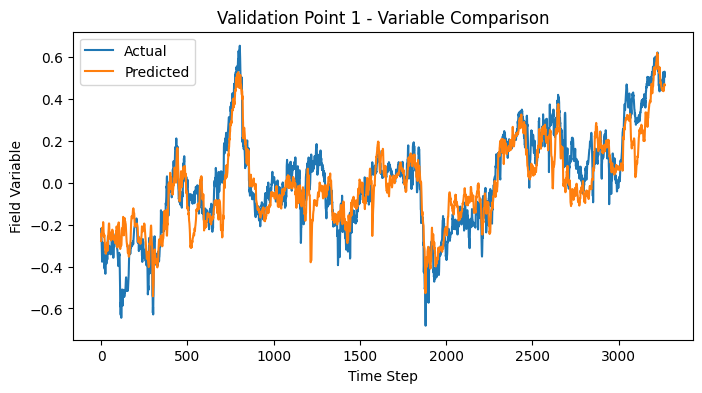

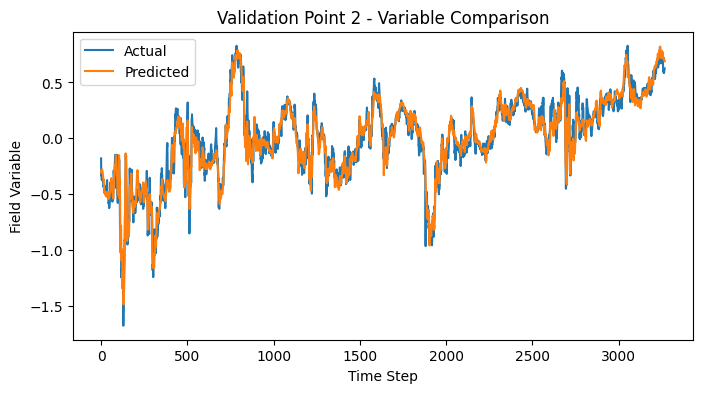

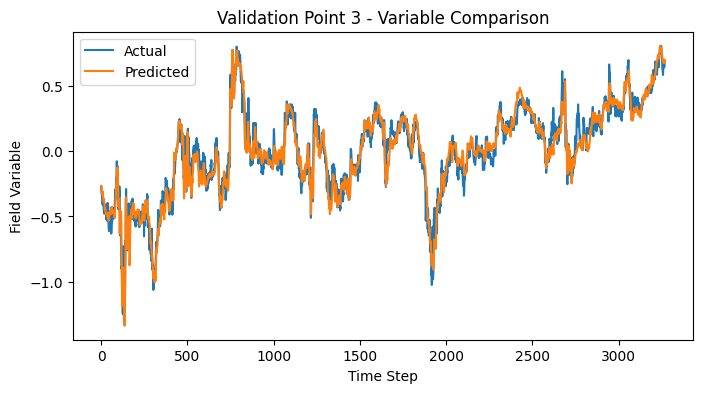

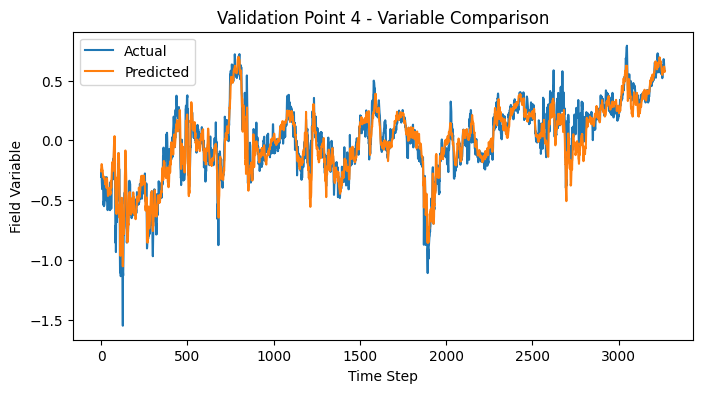

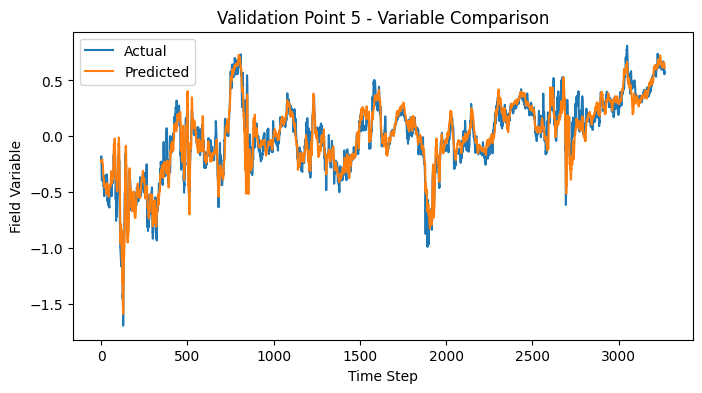

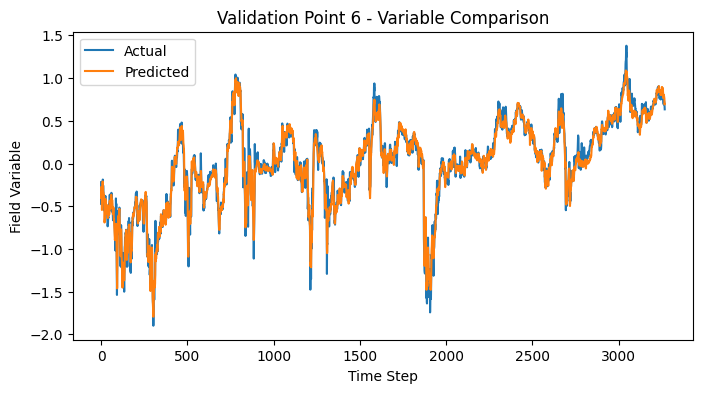

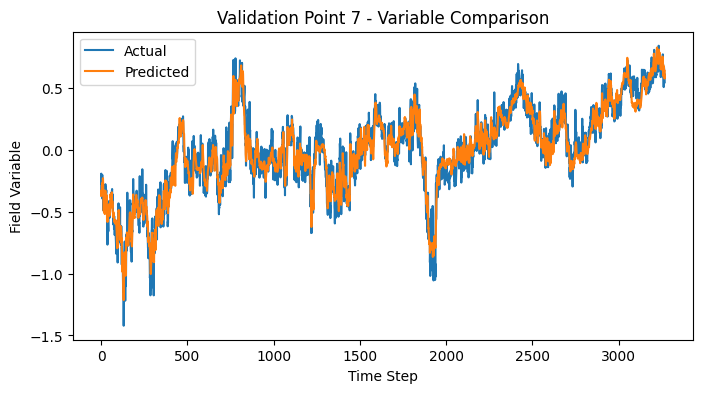

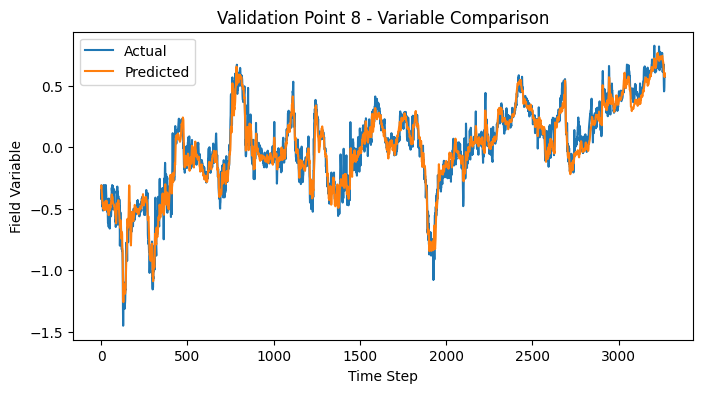

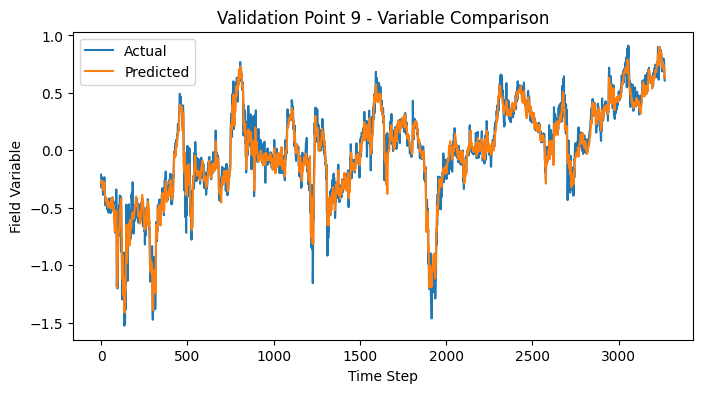

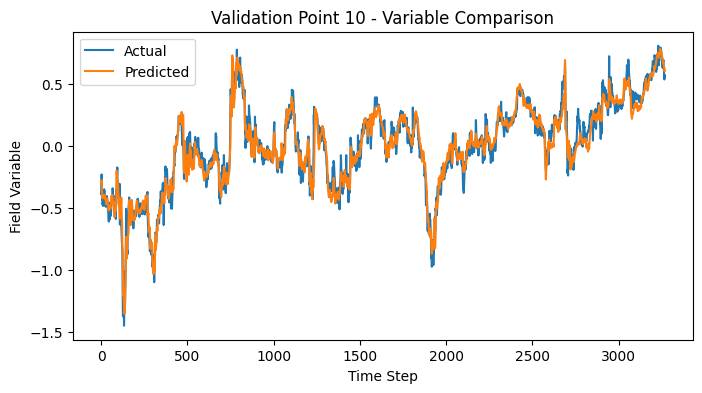

In [34]:
pred_T_all = []
actual_T_all = []
val_T_all = []

for val_ind, (val_X, val_y) in enumerate(zip(X_val, y_val)):
    dataset = WindowedDataset(X=val_X, y=val_y, 
                              X_scaler=X_scaler, y_scaler=y_scaler, device=device)
    dataloader = DataLoader(dataset, batch_size=1, shuffle=False)
    
    y_actual_point = []
    y_preds_point = []
    
    for i, (X_batch, y_batch) in enumerate(dataloader):
        with torch.no_grad():
            y_pred = model(X_batch)
        y_pred = y_pred.cpu().numpy()
        y_pred = y_scaler.inverse_transform(y_pred)
        
        y = y_batch.cpu().numpy()
        y = y_scaler.inverse_transform(y)
        
        y_actual_point.append(y)
        y_preds_point.append(y_pred)
    
    y_actual_point = np.array(y_actual_point).reshape(-1, 3)
    y_preds_point = np.array(y_preds_point).reshape(-1, 3)

    # Reconstruct variable fields
    pred_T = reconstruct_field(phi[val_ind][np.newaxis, :], y_preds_point[np.newaxis, :, 1:], y_preds_point[np.newaxis, :, 0])
    actual_T = reconstruct_field(phi[val_ind][np.newaxis, :], y_actual_point[np.newaxis, :, 1:], y_actual_point[np.newaxis, :, 0])
    val_T = reconstruct_field(phi[val_ind][np.newaxis, :], val_y[np.newaxis, :, 1:], val_y[np.newaxis, :, 0])
    
    pred_T_all.append(pred_T)
    actual_T_all.append(actual_T)
    val_T_all.append(val_T)
    
    # Plot actual vs predicted field for the first vertical layer (example)
    plt.figure(figsize=(8, 4))
    layer = 22  # Example layer index
    plt.plot(actual_T[0, :, layer], label='Actual')
    plt.plot(pred_T[0, :, layer], label='Predicted')
    plt.xlabel('Time Step')
    plt.ylabel('Field Variable')
    plt.title(f'Validation Point {val_ind + 1} - Variable Comparison')
    plt.legend()
    plt.show()

In [25]:
# Compute Mean Squared Error on Reconstructed Fields
pred_T_all = np.array(pred_T_all).squeeze()      # Shape: (n_val_points, nz, nt)
actual_T_all = np.array(actual_T_all).squeeze()  # Shape: (n_val_points, nz, nt)
val_T_all = np.array(val_T_all).squeeze()        # Shape: (n_val_points, nz, nt)
mse = torch.nn.functional.mse_loss(torch.tensor(pred_T_all), torch.tensor(actual_T_all))
print(f"Mean Squared Error on Reconstructed Fields: {mse.item():.4f}")

Mean Squared Error on Reconstructed Fields: 0.0074
